In [ ]:
!pip install bitsandbytes transformers accelerate peft -q
!pip install git+https://github.com/huggingface/diffusers.git -q
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
--2024-12-12 22:16:14--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84922 (83K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  82.93K  --.-KB/s    in 0.002s  

2024-12-12 22:16:14 (39.3 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [84922/84922]



In [ ]:
from huggingface_hub import snapshot_download

local_dir = "./dog/"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

alvan-nee-9M0tSjb-cpA-unsplash.jpeg:   0%|          | 0.00/677k [00:00<?, ?B/s]

alvan-nee-eoqnr8ikwFE-unsplash.jpeg:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

alvan-nee-bQaAJCbNq3g-unsplash.jpeg:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

alvan-nee-brFsZ7qszSY-unsplash.jpeg:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

alvan-nee-Id1DBHv4fbg-unsplash.jpeg:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

'/content/dog'

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

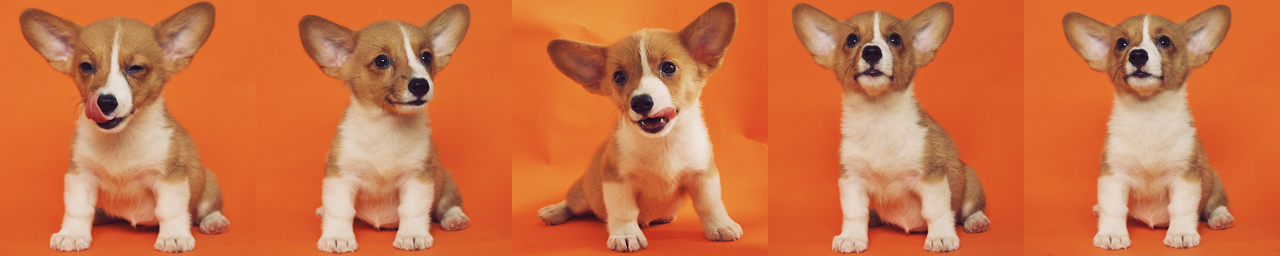

In [ ]:
import glob

# change path to display images from your local dir
img_paths = "./dog/*.jpeg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

## Generate custom captions with BLIP
Load BLIP to auto caption your images:

In [ ]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "./dog/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpeg")]

In [ ]:
import json

caption_prefix = "a photo of TOK dog, " #@param
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

### for some memory

In [ ]:
import gc

# delete the BLIP pipelines and free up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

## Prep for training

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="dog" \
  --output_dir="corgy_dog_LoRA" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="a photo of TOK dog" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=717 \
  --seed="0"

2024-12-12 22:22:29.300890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 22:22:29.336021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 22:22:29.345663: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 22:22:31.060597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
12/12/2024 22:22:35 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

tokenizer/tokenizer_config.json: 100% 737/737 [00:00<00:00, 3.12MB/s]
toke

In [ ]:
from huggingface_hub import whoami
from pathlib import Path
#@markdown make sure the `output_dir` you specify here is the same as the one used for training
output_dir = "corgy_dog_LoRA" #@param
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

In [ ]:
repo_id

'osmanh/corgy_dog_LoRA'

In [ ]:
# push to the hub🔥
from train_dreambooth_lora_sdxl import save_model_card
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
save_model_card(
    repo_id = repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    instance_prompt="a photo of TOK dog",
    validation_prompt=None,
    repo_folder=output_dir,
    vae_path="madebyollin/sdxl-vae-fp16-fix",
    use_dora = False,
)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

events.out.tfevents.1734042314.012be01fe75f.2698.1:   0%|          | 0.00/3.29k [00:00<?, ?B/s]

events.out.tfevents.1734042314.012be01fe75f.2698.0:   0%|          | 0.00/104k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/osmanh/corgy_dog_LoRA/commit/5c2ce8d2f62728c4d63aa8ad23d347ebfe1a0afc', commit_message='End of training', commit_description='', oid='5c2ce8d2f62728c4d63aa8ad23d347ebfe1a0afc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/osmanh/corgy_dog_LoRA', endpoint='https://huggingface.co', repo_type='model', repo_id='osmanh/corgy_dog_LoRA'), pr_revision=None, pr_num=None)

In [ ]:
from IPython.display import display, Markdown

link_to_model = f"https://huggingface.co/{repo_id}"
display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Your model has finished training.
Access it here: https://huggingface.co/osmanh/corgy_dog_LoRA

## prediction

In [ ]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(repo_id)
_ = pipe.to("cuda")

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

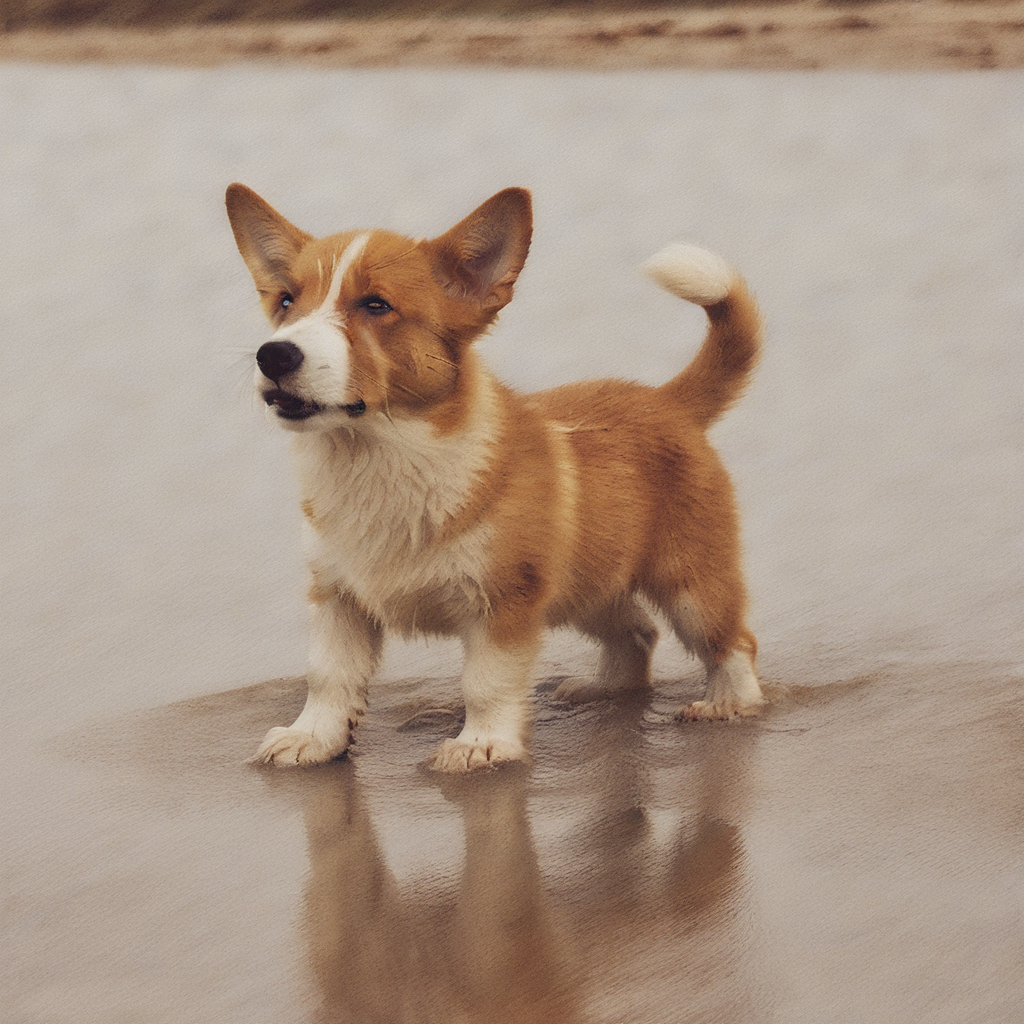

In [ ]:
prompt = "a photo of TOK dog in a sea at the beach" # @param

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image